In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('../../data/통합데이터/general_customers.csv')

C:\Users\johnh\AppData\Local\Temp\ipykernel_21692\2026942659.py:1: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/통합데이터/general_customers.csv')


In [6]:
df = df.head(2000)

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# df 경로는 각자 설정
df = pd.read_csv("../../data/통합데이터/Final_merged_all_data.csv")
# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    # 1. 감소하는 경우(음수)만 추출, 나머지는 0으로 대치
    # (음수 값에 -1을 곱해 양수로 만듦: -5000 -> 5000)
    # 즉, 값이 클수록 '많이 줄어듦'을 의미하게 됨
    negative_slopes = df_final[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 2. 0~1 사이 값으로 정규화 (MinMax Scaling)
    # 가장 많이 줄어든 사람이 1.0, 안 줄어든 사람이 0.0
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)
# -------------------------------------------------------
# 가중치 설정 (비즈니스 중요도에 따라 조절 가능)
W_SPEND = 40   # 소비 감소 비중
W_BALANCE = 30 # 잔액 감소(이탈준비) 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 현재 연체 등 리스크 비중

# (1) 리스크 점수 별도 계산 (0 or 10점)
# 연체나 승인거절이 하나라도 있으면 10점 만점 부여
has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) | 
    (df_final.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# (2) 최종 스코어 계산
df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) + 
    (score_balance_norm * W_BALANCE) + 
    (score_count_norm * W_COUNT) + 
    (has_risk * W_RISK)
)

# 소수점 정리
df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

# 출력
print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
56996  SYN_6996 -259949.057143 -466081.371429         65.5
52794  SYN_2794 -252282.000000 -115305.971429         59.9
53968  SYN_3968 -243906.428571 -117226.657143         51.1
59037  SYN_9037 -229686.857143 -119831.371429         47.7
55559  SYN_5559 -269313.542857  -44089.685714         45.9
53956  SYN_3956 -222279.228571 -168815.114286         42.1
55455  SYN_5455 -223850.714286  -61721.000000         41.3
55296  SYN_5296 -206826.314286 -381888.542857         41.0
53442  SYN_3442 -168908.285714 -186469.485714         39.1
51527  SYN_1527 -186951.657143 -241112.200000         38.0


In [14]:
df_head = df_final.head(2000)

분석 대상 변수 개수: 858개

[SHAP Summary Plot]


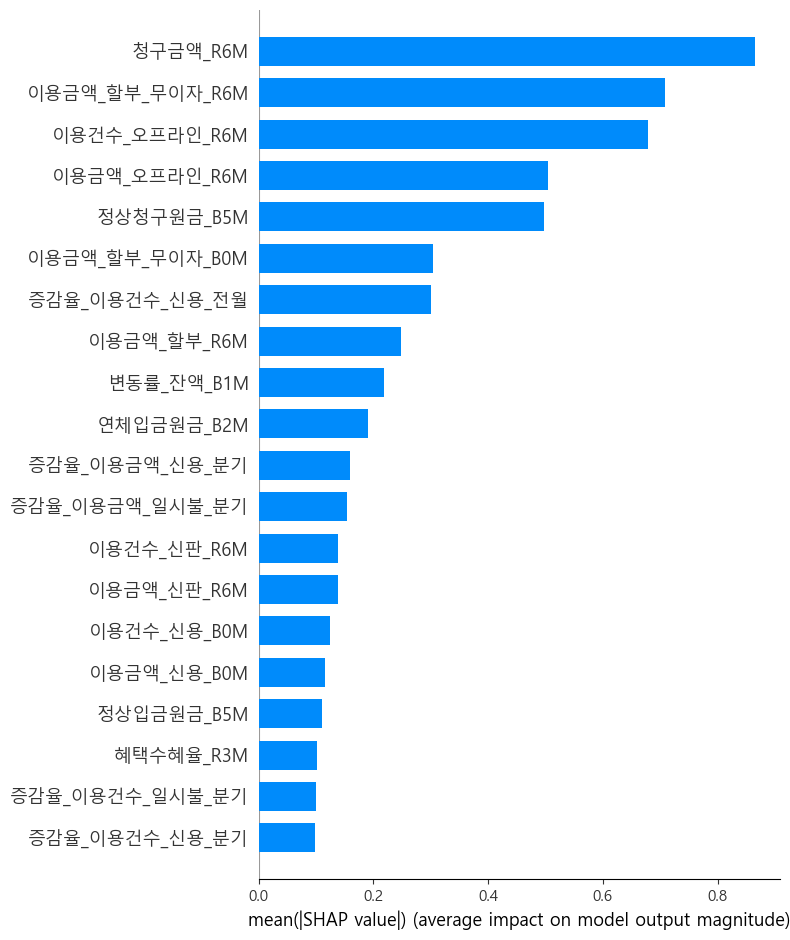

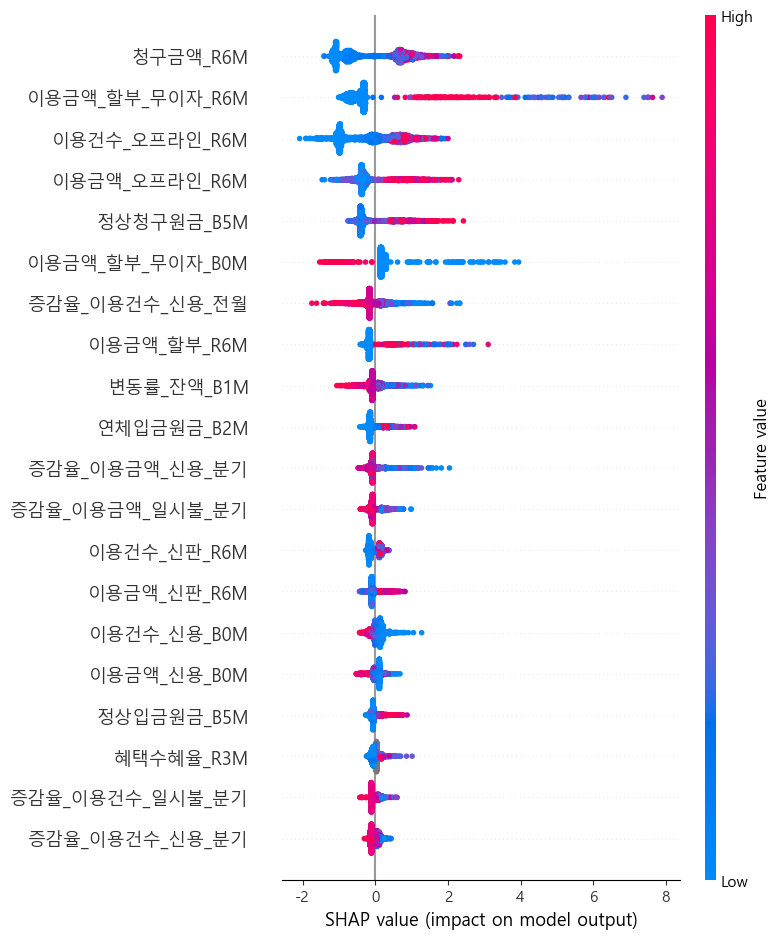

In [21]:
# ==========================================
# 5. XGBoost 모델 학습 및 SHAP 분석 수행
# ==========================================
import shap
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# (1) 분석 대상 변수(X)와 타겟(y) 설정
target = 'Churn_Score'

# ID컬럼 및 Target 제외하고 수치형 변수만 선택
numeric_cols = df_head.select_dtypes(include=[np.number]).columns
features = [col for col in numeric_cols if col not in [target, '발급회원번호', '기준년월']]

X = df_head[features]
y = df_head[target]

print(f"분석 대상 변수 개수: {len(features)}개")

# (2) XGBRegressor 모델 학습
# 별도 튜닝 없이 기본값 + 빠른 학습을 위한 설정 사용
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X, y)

# (3) SHAP Value 계산
# TreeExplainer는 트리 기반 모델에 최적화되어 빠름
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# (4) SHAP Summary Plot 시각화
print("\n[SHAP Summary Plot]")
shap.summary_plot(shap_values, X, plot_type='bar')
shap.summary_plot(shap_values, X)

In [24]:
# 3. SHAP 지수 뽑기 (전체 데이터 대상)
# TreeExplainer를 사용하여 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 4. 순위 및 SHAP 중요도 정리
# 각 변수의 SHAP 절대값 평균으로 중요도 산출
shap_sum = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_Importance': shap_sum
})

# 중요도가 높은 순서대로 정렬 및 순위 매기기
importance_df = importance_df.sort_values(by='SHAP_Importance', ascending=False).reset_index(drop=True)
importance_df['Rank'] = importance_df.index + 1

# 5. CSV 파일로 저장
importance_df.to_csv('General_SHAP_Importance.csv', index=False, encoding='utf-8-sig')

print("\n📊 [SHAP Feature Importance Top 10] 📊")
print(importance_df.head(10))
print("\n'General_SHAP_Importance.csv' 파일로 저장했어! 확인해봐! 😊")


📊 [SHAP Feature Importance Top 10] 📊
           Feature  SHAP_Importance  Rank
0         청구금액_R6M         0.865388     1
1  이용금액_할부_무이자_R6M         0.708001     2
2    이용건수_오프라인_R6M         0.678150     3
3    이용금액_오프라인_R6M         0.504814     4
4       정상청구원금_B5M         0.497322     5
5  이용금액_할부_무이자_B0M         0.304208     6
6   증감율_이용건수_신용_전월         0.299706     7
7      이용금액_할부_R6M         0.248895     8
8       변동률_잔액_B1M         0.218284     9
9       연체입금원금_B2M         0.190297    10

'General_SHAP_Importance.csv' 파일로 저장했어! 확인해봐! 😊


In [ ]:
shap_values